In [12]:
from seq_net import *
sess = tf.Session()
net = SeqNet(sess)
%load_ext line_profiler

In [2]:
import os
import pickle

data = {}
for f in os.listdir('data'):
    data[f[:-2]] = pickle.load(open('data/' + f, 'rb'), encoding='latin1')
    
labels = [x for x in data]
testing = ['NF2']
training = [x for x in labels if x != 'NF2']

val = []
tran = []

In [3]:
for x in data:
    print(x, len(data[x]))

TADA2B 189
CCDC101 148
NF2 222
TADA1 108
NF1 735
HPRT1 63
CUL3 153
MED12 1847


In [14]:
from tqdm import trange
import random 
for i in trange(500):
    gene = random.choice(training)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    #%lprun -f SeqNet.multi_path net.train(samples, 10)
    tran.append(net.train(samples, 50))
    gene = random.choice(testing)
    samples = [(dna_vec(a), b) for a, b in data[gene]]
    if i % 2 + 1:
        val.append(net.evaluate(samples, 10))
    else:
        val.append(val[-1])

100%|██████████| 500/500 [45:58<00:00,  2.96s/it]  


In [16]:
# Save training data

pickle.dump(val, open('results/validation.p', 'wb'))
pickle.dump(tran, open('results/training.p', 'wb'))

In [10]:
# Load old data

val = pickle.load(open('results/validation.p', 'rb'))
tran = pickle.load(open('results/training.p', 'rb'))

In [17]:
# Save weights

saver = tf.train.Saver()
saver.save(net.sess, 'results/model.ckpt')

'results/model.ckpt'

In [13]:
# Load weights

saver = tf.train.Saver()
saver.restore(net.sess, 'results/model.ckpt')

INFO:tensorflow:Restoring parameters from results/model.ckpt


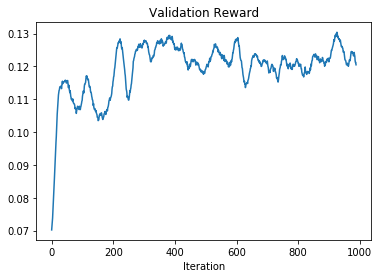

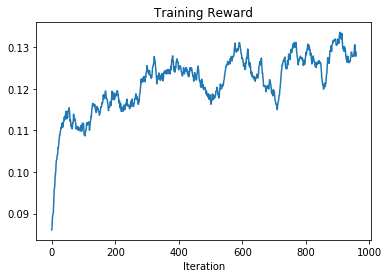

In [7]:
import matplotlib.pyplot as plt
import numpy as np

smooth = 20
plt.title('Validation Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(val, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/validation.png')
plt.show()

smooth = 50
plt.title('Training Reward')
plt.xlabel('Iteration')
plt.plot(np.convolve(tran, [1 / smooth] * smooth)[smooth:-smooth])
plt.savefig('results/training.png')
plt.show()

In [8]:
times = []

In [13]:
test_data = data[random.choice(testing)]

s, a, r = net.path([(dna_vec(a), b) for a, b in test_data])
top3 = sorted(test_data, key=lambda x: x[1])[-3:]
done = 0

print('top 3')
for x in top3:
    print(*x)

print()
print('state\t\t\t', 'rate\t\t', 'action\t\t\t', 'reward\t\t')
for i, (state, action, reward) in enumerate(zip(s, a, r)):
    best_seen = state[-1]# max(state, key=lambda x: x[1])
    if vec_dna(best_seen[0]) in [x[0] for x in top3] and not done:
        times.append(i)
        done = 1
    print(vec_dna(best_seen[0]), '\t', '%.5f' % best_seen[1], '\t', vec_dna(action), '\t', '%.5f' % reward)

top 3
TGAAAAGGCCCAGATCACCG 0.856509475
GCTTGGTACGCAGAGCACCG 0.861398837
GCACAATGAGAACTCCGACA 0.871919619

state			 rate		 action			 reward		
GCTGCTTGGAGTGGATGCCC 	 0.02221 	 GTACATTTAAGAGAACCCCG 	 0.04888
GGTCATAAATGTGAAGCCCC 	 0.08146 	 GCTTCTTTCAGACTACGCAG 	 0.01222
GCTGCTTGGAGTGGATGCCC 	 0.02221 	 GGATCTTTCGGGCTACCCAG 	 0.22154
TGAGCTTCAGCTCTCTCAAG 	 0.40279 	 CCATATTTCAGAATACCCAG 	 0.06990
CCAGTTTACTATTAAACCAC 	 0.13980 	 GCATTATTCGGCATACCCAG 	 0.38763
GCTTGGTACGCAGAGCACCG 	 0.86140 	 GCATCATTAGGAGTTAACCG 	 0.00000
GCTTGGTACGCAGAGCACCG 	 0.00000 	 GCAGTAATACGGCAACCCGG 	 0.12541
AAAGATCTACTGCCCTCCTG 	 0.25082 	 GCACCAATAAGGGAACCCAG 	 0.35164
GTACACAATCAAGGACACAG 	 0.70327 	 GGTTGAATAAGACAACCCCG 	 0.00000
GGTCATAAATGTGAAGCCCC 	 0.00000 	 ACATGAATAAAGCAGCGCAG 	 0.12281
AAAGGCCCAGATCACCGAGG 	 0.24562 	 GCTCGTTTAGGACTTCCCAG 	 0.06937
ACTGGATCATGATGTTTCAA 	 0.13874 	 TCATCTATCGGACTTTCCAG 	 0.00000
TGAGCTTCAGCTCTCTCAAG 	 0.00000 	 GCATCTATAGGATATCACCG 	 0.00000
GCTTGGTACGCAGAGCACCG 	 0.00

In [ ]:
print(np.mean(np.array(times)))